In [28]:
from huggingface_hub import hf_hub_download
import shutil
from pathlib import Path

DATASET_DIR = Path.cwd().parent / "datasets" / "mehyaar"
JSON_ANNOTATED_DIR = DATASET_DIR / "ResumesJsonAnnotated"
PDFS_DIR = DATASET_DIR / "ResumesPDF"

if DATASET_DIR.exists():
    print("Dataset already loaded")
else:
    DATASET_DIR.mkdir()
    annotated_zip = hf_hub_download(
        repo_id="Mehyaar/Annotated_NER_PDF_Resumes",
        repo_type="dataset",
        filename="ResumesJsonAnnotated.zip",
    )
    shutil.unpack_archive(annotated_zip, DATASET_DIR)
    print("Loaded json annotated resumes")
    pdfs_zip = hf_hub_download(
        repo_id="Mehyaar/Annotated_NER_PDF_Resumes",
        repo_type="dataset",
        filename="ResumesPDF.zip",
    )
    shutil.unpack_archive(pdfs_zip, DATASET_DIR)
    print("Loaded source pdfs")

Loaded json annotated resumes
Loaded source pdfs


In [5]:
import json
import os

data = []
for filename in os.listdir(JSON_ANNOTATED_DIR):
    if filename.endswith(".json"):
        with open(os.path.join(JSON_ANNOTATED_DIR, filename), "r") as file:
            data.append(json.load(file))

first_cv = data[0]
text = first_cv["text"]
annotations = first_cv["annotations"]

print(f"Text: {text}")
print(f"Annotations: {annotations}")

Text:   Roy A. Jaleco Jr.                                E-mail: ra.jaleco@yahoo.com § Phone:  +97158 882 6544                   440 The Centre Residence Al Muteena Deira Dubai, UAE EDUCATION Bachelor of Science in Information Technology                                                2006 — 2013 Adamson University Secondary                                                                                                              2001 — 2006 Grant’s Apostolic Institute Primary                                                                                                                 1996 — 2002 Grant’s Apostolic Institute  WORK EXPERIENCE Destinations of the World                                                       January 2017- February 2018 Data Entry Operator Mandaluyong, Philippines  • Accommodating requests from Partner Hotels all over the world together with the company’s Contract managers. • Process Updates based on Hotel’s preference. • Creation of Promotional Offers for

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
import numpy as np

def basic_dataset_info(data):
    print("=== BASIC DATASET OVERVIEW ===")
    print(f"Total number of CVs: {len(data)}")

    text_lengths = [len(cv["text"]) for cv in data]
    annotation_counts = [len(cv["annotations"]) for cv in data]

    print(f"Average text length: {np.mean(text_lengths):.0f} characters")
    print(f"Average annotations per CV: {np.mean(annotation_counts):.1f}")
    print(f"Min text length: {min(text_lengths)}")
    print(f"Max text length: {max(text_lengths)}")
    print(f"Min annotations: {min(annotation_counts)}")
    print(f"Max annotations: {max(annotation_counts)}")

    return text_lengths, annotation_counts

text_lengths, annotation_counts = basic_dataset_info(data)

=== BASIC DATASET OVERVIEW ===
Total number of CVs: 5029
Average text length: 4441 characters
Average annotations per CV: 107.1
Min text length: 0
Max text length: 99973
Min annotations: 0
Max annotations: 591


In [ ]:
def analyze_annotation_types(data):
    print("\n=== ANNOTATION TYPE ANALYSIS ===")

    all_annotations = []
    for cv in data:
        all_annotations.extend(cv["annotations"])

    annotation_types = []
    for ann in all_annotations:
        if len(ann) >= 3:
            ann_type = ann[2].split(':')[0] if ':' in ann[2] else ann[2]
            annotation_types.append(ann_type)

    type_counts = Counter(annotation_types)

    print("Annotation types and their frequencies:")
    for ann_type, count in type_counts.most_common():
        print(f"  {ann_type}: {count} ({count/len(all_annotations)*100:.1f}%)")

    return all_annotations, annotation_types, type_counts

all_annotations, annotation_types, type_counts = analyze_annotation_types(data)


=== ANNOTATION TYPE ANALYSIS ===
Annotation types and their frequencies:
  SKILL: 538482 (100.0%)


In [ ]:
def analyze_skills(data):
    print("\n=== SKILLS ANALYSIS ===")

    skills = []
    skill_patterns = []

    for cv in data:
        for ann in cv["annotations"]:
            if len(ann) >= 3 and 'SKILL' in ann[2]:
                skill_full = ann[2]
                skill_name = skill_full.split(': ')[1] if ': ' in skill_full else skill_full
                skills.append(skill_name.lower().strip())

                start, end = ann[0], ann[1]
                skill_text = cv["text"][start:end]
                skill_patterns.append(skill_text)

    skill_counts = Counter(skills)
    skill_pattern_counts = Counter(skill_patterns)

    print("Top 20 most frequent skills:")
    for skill, count in skill_counts.most_common(20):
        print(f"  {skill}: {count}")

    return skills, skill_counts, skill_patterns, skill_pattern_counts

skills, skill_counts, skill_patterns, skill_pattern_counts = analyze_skills(data)


=== SKILLS ANALYSIS ===
Top 20 most frequent skills:
  com: 3874
  skills: 3805
  work: 3679
  personal: 3458
  knowledge: 3417
  english: 3399
  gmail: 3238
  project: 2683
  professional: 2661
  information: 2643
  hindi: 2636
  company: 2617
  nationality: 2588
  management: 2562
  team: 2499
  office: 2465
  is: 2406
  technical: 2401
  engineering: 2358
  organization: 2344


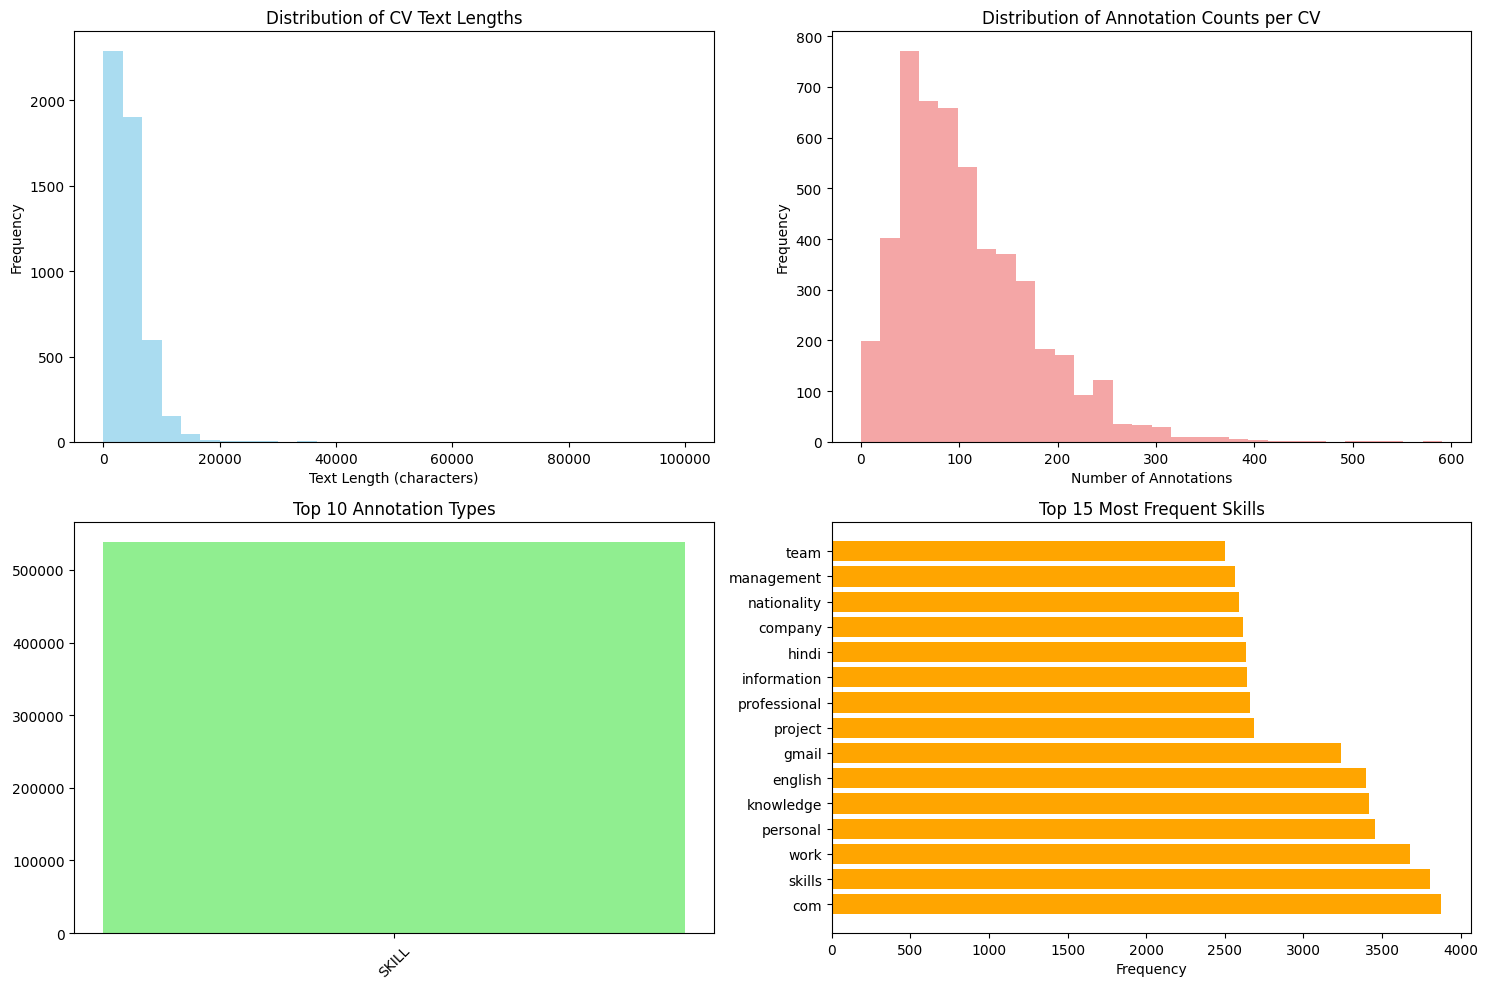

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0,0].hist(text_lengths, bins=30, alpha=0.7, color='skyblue')
axes[0,0].set_title('Distribution of CV Text Lengths')
axes[0,0].set_xlabel('Text Length (characters)')
axes[0,0].set_ylabel('Frequency')

axes[0,1].hist(annotation_counts, bins=30, alpha=0.7, color='lightcoral')
axes[0,1].set_title('Distribution of Annotation Counts per CV')
axes[0,1].set_xlabel('Number of Annotations')
axes[0,1].set_ylabel('Frequency')

if type_counts:
    types, counts = zip(*type_counts.most_common(10))
    axes[1,0].bar(types, counts, color='lightgreen')
    axes[1,0].set_title('Top 10 Annotation Types')
    axes[1,0].tick_params(axis='x', rotation=45)

if skill_counts:
    top_skills, skill_counts_vals = zip(*skill_counts.most_common(15))
    axes[1,1].barh(top_skills, skill_counts_vals, color='orange')
    axes[1,1].set_title('Top 15 Most Frequent Skills')
    axes[1,1].set_xlabel('Frequency')

plt.tight_layout()
plt.show()

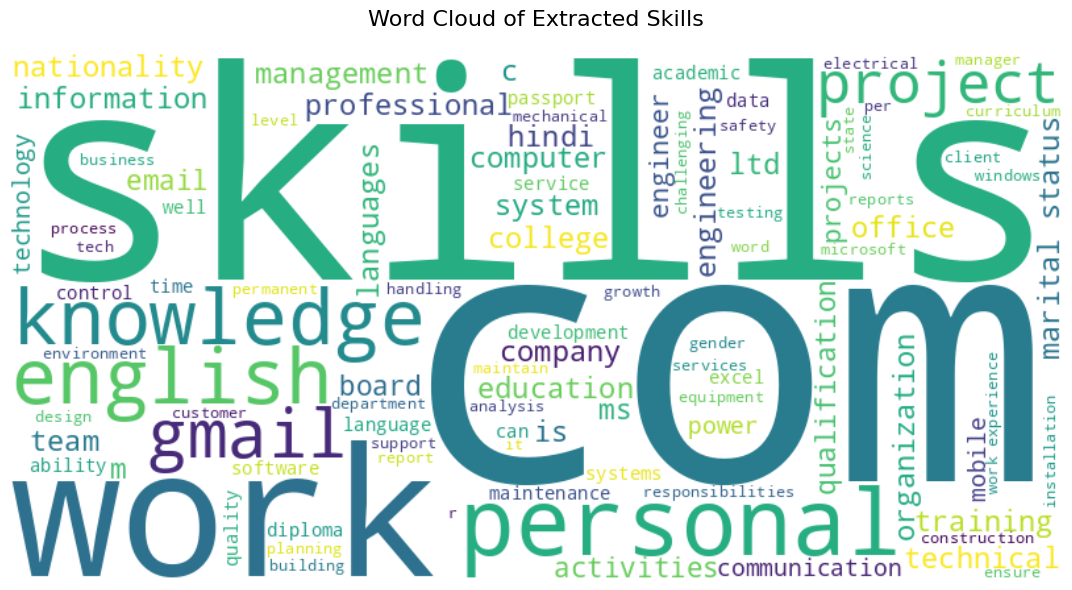

In [ ]:
def create_skills_wordcloud(skill_counts):
    if skill_counts:

        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            colormap='viridis',
            max_words=100
        ).generate_from_frequencies(skill_counts)

        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud of Extracted Skills', fontsize=16, pad=20)
        plt.tight_layout()
        plt.show()

create_skills_wordcloud(skill_counts)

In [ ]:
def analyze_annotation_positions(data):
    print("\n=== ANNOTATION POSITION ANALYSIS ===")

    relative_positions = []
    annotation_lengths = []

    for cv in data:
        text_length = len(cv["text"])
        for ann in cv["annotations"]:
            if len(ann) >= 3:
                start, end = ann[0], ann[1]

                rel_pos = start / text_length
                relative_positions.append(rel_pos)
                annotation_lengths.append(end - start)

    print(f"Average annotation length: {np.mean(annotation_lengths):.1f} characters")
    print(f"Average relative position: {np.mean(relative_positions):.3f}")

    return relative_positions, annotation_lengths

relative_positions, annotation_lengths = analyze_annotation_positions(data)


=== ANNOTATION POSITION ANALYSIS ===
Average annotation length: 9.1 characters
Average relative position: 0.433


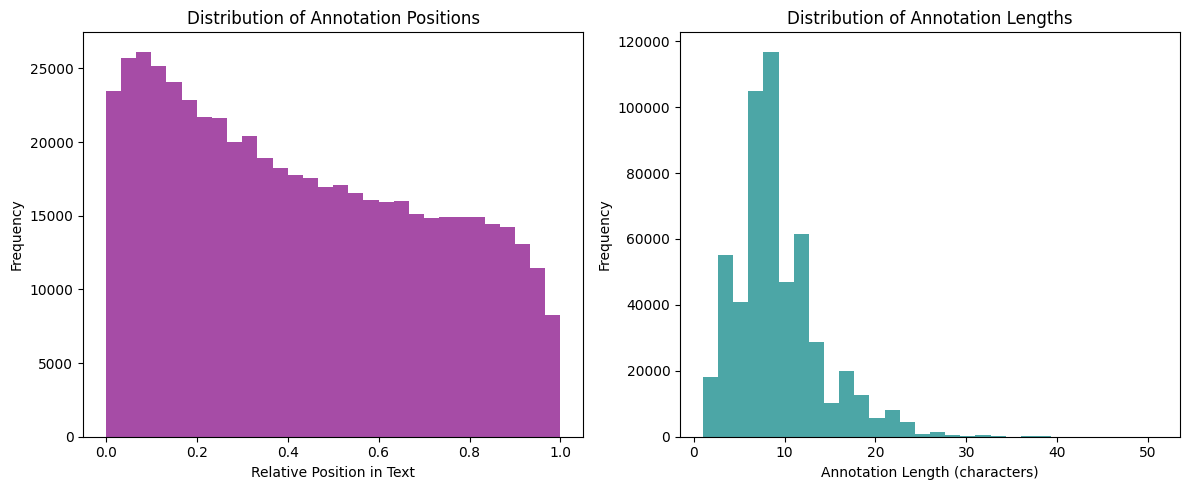

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(relative_positions, bins=30, alpha=0.7, color='purple')
axes[0].set_title('Distribution of Annotation Positions')
axes[0].set_xlabel('Relative Position in Text')
axes[0].set_ylabel('Frequency')

axes[1].hist(annotation_lengths, bins=30, alpha=0.7, color='teal')
axes[1].set_title('Distribution of Annotation Lengths')
axes[1].set_xlabel('Annotation Length (characters)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
def analyze_cv_content(data):
    print("\n=== CV CONTENT ANALYSIS ===")

    sections = ['education', 'experience', 'skills', 'projects', 'summary', 'contact']
    section_occurrences = {section: 0 for section in sections}

    education_keywords = ['university', 'college', 'degree', 'b.tech', 'm.tech', 'bachelor', 'master']
    experience_keywords = ['experience', 'worked', 'employed', 'job', 'position']
    skill_keywords = ['skills', 'technologies', 'programming', 'languages']

    for cv in data:
        text_lower = cv["text"].lower()

        for section in sections:
            if section in text_lower:
                section_occurrences[section] += 1

        if any(keyword in text_lower for keyword in education_keywords):
            section_occurrences['education'] += 1

        if any(keyword in text_lower for keyword in experience_keywords):
            section_occurrences['experience'] += 1

    print("Section occurrences across CVs:")
    for section, count in section_occurrences.items():
        percentage = (count / len(data)) * 100
        print(f"  {section.title()}: {count} ({percentage:.1f}%)")

    return section_occurrences

section_occurrences = analyze_cv_content(data)


=== CV CONTENT ANALYSIS ===
Section occurrences across CVs:
  Education: 7558 (150.3%)
  Experience: 8661 (172.2%)
  Skills: 3879 (77.1%)
  Projects: 1834 (36.5%)
  Summary: 1230 (24.5%)
  Contact: 1474 (29.3%)


In [ ]:
if skill_counts:
    skills_df = pd.DataFrame({
        'skill': list(skill_counts.keys()),
        'count': list(skill_counts.values())
    }).sort_values('count', ascending=False).head(50)

    fig = px.treemap(skills_df,
                     path=['skill'],
                     values='count',
                     title='Skills Distribution Treemap (Top 50)',
                     color='count',
                     color_continuous_scale='Blues')
    fig.show()

In [ ]:
def calculate_quality_metrics(data):
    print("\n=== Annotation METRICS ===")

    metrics = {
        'cv_with_annotations': 0,
        'avg_annotations_per_cv': 0,
        'annotation_density': [],
        'overlapping_annotations': 0
    }

    total_annotations = 0
    total_text_length = 0

    for cv in data:
        text_length = len(cv["text"])
        ann_count = len(cv["annotations"])

        total_annotations += ann_count
        total_text_length += text_length

        if ann_count > 0:
            metrics['cv_with_annotations'] += 1

        density = (ann_count / text_length) * 1000 if text_length > 0 else 0
        metrics['annotation_density'].append(density)

    metrics['avg_annotations_per_cv'] = total_annotations / len(data)
    avg_density = np.mean(metrics['annotation_density'])

    print(f"CVs with annotations: {metrics['cv_with_annotations']}/{len(data)}")
    print(f"Average annotations per CV: {metrics['avg_annotations_per_cv']:.1f}")
    print(f"Average annotation density: {avg_density:.2f} per 1000 chars")

    return metrics

quality_metrics = calculate_quality_metrics(data)


=== Annotation METRICS ===
CVs with annotations: 4971/5029
Average annotations per CV: 107.1
Average annotation density: 26.78 per 1000 chars
